<a href="https://colab.research.google.com/github/skywalker0803r/teaching_material/blob/main/Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron 基礎介紹

感知器（英語：Perceptron）是Frank Rosenblatt在1957年就職於康奈爾航空實驗室（Cornell Aeronautical Laboratory）時所發明的一種人工神經網路。它可以被視為一種最簡單形式的前饋神經網路，是一種二元線性分類器。

Frank Rosenblatt給出了相應的感知機學習算法，常用的有感知機學習、最小二乘法和梯度下降法。譬如，感知機利用梯度下降法對損失函數進行極小化，求出可將訓練數據進行線性劃分的分離超平面，從而求得感知機模型。

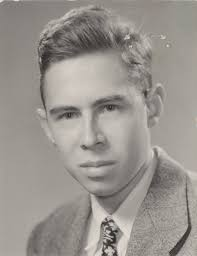

神經細胞結構示意圖
感知機是生物神經細胞的簡單抽象。神經細胞結構大致可分為：樹突、突觸、細胞體及軸突。單個神經細胞可被視為一種只有兩種狀態的機器——激動時為『是』，而未激動時為『否』。神經細胞的狀態取決於從其它的神經細胞收到的輸入信號量，及突觸的強度（抑制或加強）。當信號量總和超過了某個閾值時，細胞體就會激動，產生電脈衝。電脈衝沿著軸突並通過突觸傳遞到其它神經元。為了模擬神經細胞行為，與之對應的感知機基礎概念被提出，如權量（突觸）、偏置（閾值）及激活函數（細胞體）。

在人工神經網絡領域中，感知機也被指為單層的人工神經網絡，以區別於較複雜的多層感知機（Multilayer Perceptron）。作為一種線性分類器，（單層）感知機可說是最簡單的前向人工神經網絡形式。儘管結構簡單，感知機能夠學習並解決相當複雜的問題。感知機主要的本質缺陷是它不能處理線性不可分問題。

![img](https://miro.medium.com/max/424/1*J0zzv7JjJOUh6ycSOVfl3Q.png)

Perceptron 在程式中實際運作流程圖如下

![img](https://pythonmachinelearning.pro/wp-content/uploads/2017/09/Single-Perceptron.png.webp)

# 課程大綱

* 1 導入函式庫
* 2 製作數據
* 3 定義感知器模型架構
* 4 訓練感知器模型(用梯度下降法)
* 5.評估感知器模型
* 6.多層感知器(multiple layer perceptron)

# 1.導入套件

In [1]:
# jax 可以想成有微分功能的numpy
import jax
import jax.numpy as jnp
from jax import random
import numpy as np

# 進度條
from tqdm import tqdm_notebook as tqdm

# 機器學習套件庫sklearn
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs

# 繪圖用
import matplotlib.pyplot as plt

# 整理&操作表格數據用
import pandas as pd

# 畫出決策表面用
def plot_decision_surface(X,predict_fn):
  min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
  min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
  x1grid = np.arange(min1, max1, 0.01)
  x2grid = np.arange(min2, max2, 0.01)
  xx, yy = np.meshgrid(x1grid, x2grid)
  r1, r2 = xx.flatten(), yy.flatten()
  r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
  grid = np.hstack((r1,r2))
  yhat = predict_fn(grid)
  zz = yhat.reshape(xx.shape)
  plt.contourf(xx, yy, zz, cmap='Paired')

# 2.製作數據

這裡以一個簡單的二分類數據當範例 特徵有 x1,x2 輸出為y(0或1)

In [2]:
X, y = make_blobs(n_samples=100,centers=2, n_features=2,random_state=0)
df = pd.DataFrame()
df['x1'] = X[:,0]
df['x2'] = X[:,1]
df['y'] = y
df.head()

,x1,x2,y
0,4.218503,2.234192,1
1,0.907799,0.459844,1
2,-0.276525,5.081278,0
3,0.088484,2.322991,0
4,3.243297,1.214606,1


針對上面的表格數據,可以用視覺化套件繪製出來幫助我們更好的理解數據

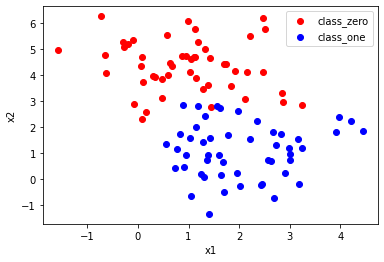

In [3]:
def plot_data(class_zero,class_one):
  plt.scatter(class_zero.x1,class_zero.x2,label='class_zero',color='red')
  plt.scatter(class_one.x1,class_one.x2,label='class_one',color='blue')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.legend()
plot_data(df[df.y == 0],df[df.y == 1])

# 3.定義感知器模型參數

在開始正式訓練之前我們先把模型建立起來 並隨機設定其中的weight(權重) 和bias(偏置) 看看這樣隨機的參數表現如何

In [4]:
# model weights 隨機設定初始值
key = random.PRNGKey(0)
params = {
    'w': random.uniform(key,minval=-1.0,maxval=1.0,shape=(2,)),
    'b': 0.
}

# model forward method
def forward(params,X):
    return jax.nn.sigmoid(jnp.dot(X,params['w'] + params['b']))

forward 輸出值經過 sigmoid函數 會被限制在0~1之間

![img](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F5152157%2F366ce717ad74dfe967a940d9a2161f9b%2Fmain-qimg-6b67bea3311c3429bfb34b6b1737fe0c.jpg?generation=1605711218576073&alt=media)



In [5]:
y_pred = forward(params,df[['x1','x2']].values)
y_pred

DeviceArray([0.26217878, 0.44142163, 0.96258616, 0.796206  , 0.24945992,
             0.70374334, 0.8725847 , 0.30773067, 0.8908764 , 0.35807458,
             0.9134364 , 0.36440393, 0.9268777 , 0.9315171 , 0.50499606,
             0.19814704, 0.12827411, 0.90262073, 0.4615074 , 0.5361069 ,
             0.90078026, 0.9067656 , 0.67655736, 0.9634862 , 0.2647489 ,
             0.914678  , 0.33175138, 0.95867646, 0.8823558 , 0.5043432 ,
             0.1820572 , 0.9011494 , 0.50954664, 0.1809794 , 0.6795155 ,
             0.78339076, 0.4456674 , 0.6131762 , 0.66066056, 0.6208687 ,
             0.85754675, 0.88971645, 0.98549336, 0.8051815 , 0.7734105 ,
             0.41860783, 0.21275859, 0.22172746, 0.9633958 , 0.9541805 ,
             0.27530482, 0.56852525, 0.91471004, 0.9081617 , 0.4728595 ,
             0.9034644 , 0.5437719 , 0.41312283, 0.27912343, 0.12462027,
             0.53793913, 0.8073177 , 0.9648636 , 0.31999302, 0.9461732 ,
             0.697632  , 0.9007727 , 0.6010229 , 0.

我們實際有兩個類別0和1,所以可以把模型原始輸出再做轉換 大於0.5的變成1小於0.5的變成0

In [6]:
y_pred = (y_pred>=0.5).astype(int)
y_pred

DeviceArray([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
             1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
             1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
             1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
             1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],            dtype=int32)

In [7]:
df['y_pred'] = list(y_pred)

看看正確率如何(訓練前)

In [8]:
accuracy_score(df['y'].values,df['y_pred'].values)

0.17

可視化預測結果

實際情況


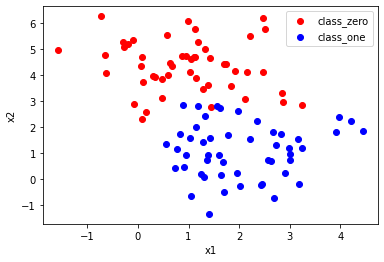

預測情況和決策邊界


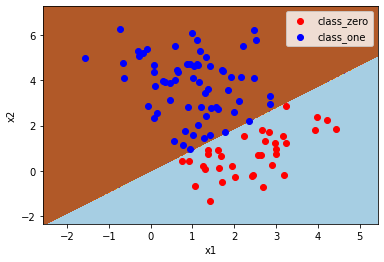

In [9]:
print('實際情況')
plot_data(df[df.y == 0],df[df.y == 1])
plt.show()
print('預測情況和決策邊界')
plot_decision_surface(df[['x1','x2']].values,lambda x:(forward(params,x)>=0.5).astype(int))
plot_data(df[df.y_pred == 0],df[df.y_pred == 1])
plt.show()

# 4.訓練感知器模型(用梯度下降法)

梯度下降解決的問題是這樣的

1.給定一個損失函數例如:J(w)

2.找到一組w讓J(w)最小

![img](https://miro.medium.com/max/700/0*owEkv2m9XluM2Ta_.png)

梯度下降求解的思路是這樣的:

1.對每一個w去計算∂J(w)/ ∂w(所謂的梯度)

2.根據梯度的方向和大小去更新w

3.通常會在梯度前面乘上一個learning_rate(控制更新步長)

![img](https://miro.medium.com/max/700/0*qKCRY2P2eAbClDcm.gif)

定義一個損失函數(loss_function)簡稱J(吃模型的參數(params)(weight和bias)吐出loss)

In [10]:
def J(params):
  y_pred = forward(params,X) # 預測值
  loss = jnp.mean(jnp.square(y_pred - y)) # 預測值跟真實值之間的mse loss
  return loss
loss = J(params)
print('loss:',loss)

loss: 0.5773976


對損失函數求偏微分(梯度),這裡使用jax套件提供的功能非常方便,可以輕鬆取得 損失函數 的 導函數

導函數複習： 若有函數 f(x) = x**2 則其導函數 f'(x) = 2x

In [11]:
grad_fn = jax.grad(J) #損失函數的導函數
grad = grad_fn(params) #利用導函數求導數(梯度)
print('grad:',grad)

grad: {'b': DeviceArray(0.07400565, dtype=float32), 'w': DeviceArray([-0.15146564,  0.22547129], dtype=float32)}


用 梯度下降公式 更新模型參數

![img](https://miro.medium.com/max/279/0*MyJf92jsXJMpumzx.png)

In [12]:
def update(params, grads,lr = 0.01): # lr代表學習率
  new_params = jax.tree_multimap(lambda p, g: p - lr * g, params, grads)
  return new_params

print('舊參數',params)
new_params = update(params,grad_fn(params))
print('新參數:',new_params)

舊參數 {'w': DeviceArray([-0.5674093 ,  0.60824823], dtype=float32), 'b': 0.0}
新參數: {'b': DeviceArray(-0.00074006, dtype=float32), 'w': DeviceArray([-0.5658946,  0.6059935], dtype=float32)}


所謂的機器學習(訓練)其實就是反覆執行多次參數更新

In [13]:
loss_history = [] # 紀錄每一步的loss
for i in tqdm(range(1000)):
  loss = J(params)
  loss_history.append(loss)
  grads = grad_fn(params)
  params = update(params, grads)
  if i%50 == 0:
    print(i,loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0 0.5773976
50 0.5067307
100 0.39113837
150 0.34271637
200 0.30199292
250 0.2574211
300 0.2162299
350 0.18447956
400 0.16191307
450 0.14602408
500 0.13460481
550 0.12615803
600 0.11972843
650 0.11470637
700 0.1106946
750 0.10742735
800 0.10472178
850 0.102448866
900 0.10051547
950 0.09885283



觀察 loss下降曲線

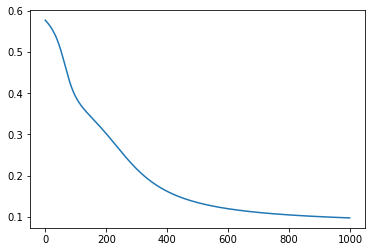

In [14]:
plt.plot(loss_history)

# 5.評估感知器模型(訓練後)

In [15]:
y_pred = forward(params,df[['x1','x2']].values)
y_pred = (y_pred>=0.5).astype(int)
df['y_pred'] = list(y_pred)
accuracy_score(df['y'].values,df['y_pred'].values)

0.87

可視化預測結果

實際情況


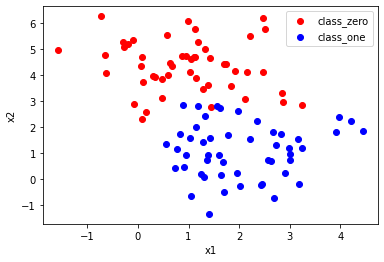

預測情況和決策邊界


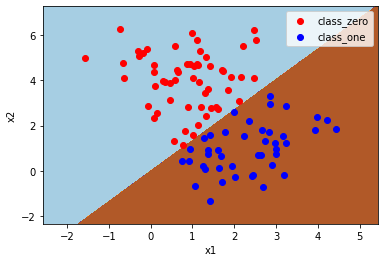

In [16]:
print('實際情況')
plot_data(df[df.y == 0],df[df.y == 1])
plt.show()
print('預測情況和決策邊界')
plot_decision_surface(df[['x1','x2']].values,lambda x:(forward(params,x)>=0.5).astype(int))
plot_data(df[df.y_pred == 0],df[df.y_pred == 1])
plt.show()

# 6.多層感知器(multiple layer perceptron)

![img](http://jihshichen.weebly.com/uploads/7/4/6/2/74629793/_2192882.png)

導入深度學習套件 tensorflow & keras

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Accuracy
from keras.losses import mean_squared_error

setting seed value

In [18]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

建立順序模型

In [19]:
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

先forward一遍 編譯(定義 optimizer & loss_function) 然後看一下模型總結

In [20]:
X = df[['x1','x2']].values
y = df['y'].values
y = model(X)
model.compile(optimizer = 'Adam',
              loss = mean_squared_error)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (100, 2)                  6         
_________________________________________________________________
dense_1 (Dense)              (100, 32)                 96        
_________________________________________________________________
dense_2 (Dense)              (100, 32)                 1056      
_________________________________________________________________
dense_3 (Dense)              (100, 1)                  33        
Total params: 1,191
Trainable params: 1,191
Non-trainable params: 0
_________________________________________________________________


訓練模型

In [21]:
X = df[['x1','x2']].values
y = df['y'].values
model.fit(X,y,epochs=1000,verbose=0)

模型預測 & 評估

In [22]:
y_pred = model.predict(X).ravel()
y_pred = (y_pred>=0.5).astype(int)
df['y_pred'] = list(y_pred)
accuracy_score(df['y'].values,df['y_pred'].values)

0.99

可視化

實際情況


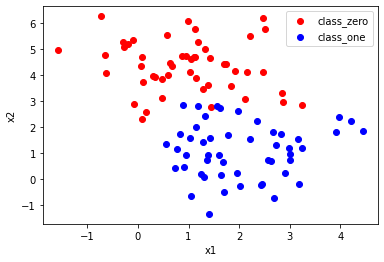

預測情況和決策邊界


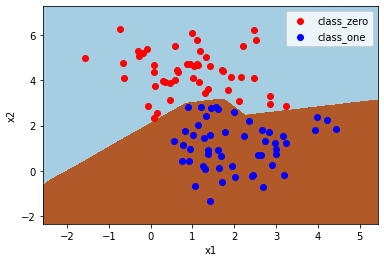

In [23]:
print('實際情況')
plot_data(df[df.y == 0],df[df.y == 1])
plt.show()
print('預測情況和決策邊界')
plot_decision_surface(df[['x1','x2']].values,lambda x:(model.predict(x).ravel()>=0.5).astype(int))
plot_data(df[df.y_pred == 0],df[df.y_pred == 1])
plt.show()